In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from sklearn.linear_model import LinearRegression
from lib.cartpoleenv import CartPoleEnv
from lib.cartpolesystem import CartPoleStepperMotorSystem, Cart, Pole
from lib.motors import StepperMotor
from lib.numerical import rk4_step

In [11]:
dt = 0.01
g = 9.81
r = 0.04456
x_max = 1.15/2
l1 = 0.225
m1 = 0.0446
m = 0.2167
u_p1 = 0.00001

cart = Cart(m, 0.01, (-x_max, x_max), 0.2)
motor = StepperMotor(r, (-2.7, 2.7), 0.3, (-1.5, 1.5), 0.2)
poles = [Pole(m1, l1, u_p1)]
system = CartPoleStepperMotorSystem(cart, motor, poles, g)

In [12]:
df = pd.read_csv('data/up_t_0.csv')
print("Entries before filter: ", len(df))
df = df.dropna()
print("Entries after filter: ", len(df))
df

Entries before filter:  7636
Entries after filter:  7635


,s,d_s,theta_1,d_theta_1,u,time,T,desired_s,error_s,desired_d_s,error_d_s,desired_theta_1,error_theta_1,desired_d_theta_1,error_d_theta_1,desired_u
0,0.054722,0.0,0.185832,0.000000,0.000000,0.000000,1.517217e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,3.141593,0.000000,0.000000,4.294618,-1.023253e-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.0,3.136991,-0.000617,0.000000,4.385526,-3.845202e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.0,3.135457,-0.000958,0.000000,4.387113,-5.126903e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,3.135457,-0.000958,0.000000,4.388787,-5.126903e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,3.483200,2.8,4.965496,-2.152955,-19.406878,81.580918,-2.247018e-01,0.164903,-3.339857,-0.177529,-2.977529,-0.007603,1.339232,0.009099,3.254059,-0.074679
7631,3.504760,2.8,4.936350,-3.244959,-26.561185,81.591020,-3.064150e-01,0.163131,-3.362629,-0.178269,-2.978269,-0.007512,1.373071,0.009102,3.355969,-0.073786
7632,3.525760,2.8,4.902603,-3.346867,-28.179382,81.600875,-3.250927e-01,0.161352,-3.385408,-0.178999,-2.978999,-0.007421,1.414579,0.009105,4.220032,-0.072893
7633,3.546760,2.8,4.861185,-4.210928,-34.454509,81.611015,-3.965827e-01,0.159565,-3.408195,-0.179721,-2.979721,-0.007331,1.462223,0.009107,4.774873,-0.071999


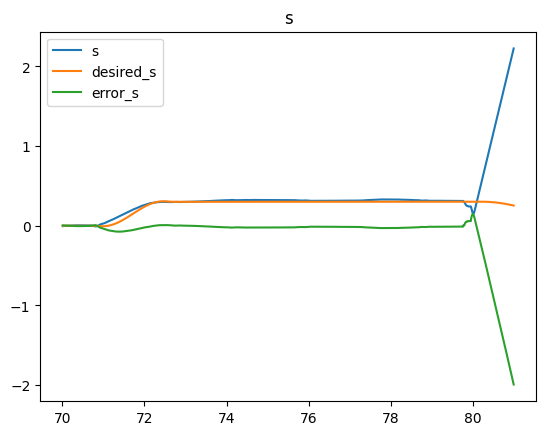

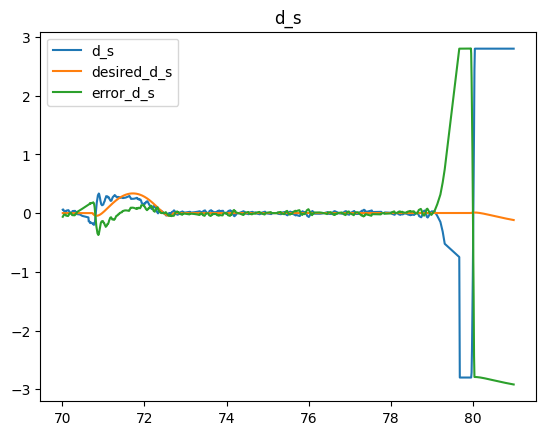

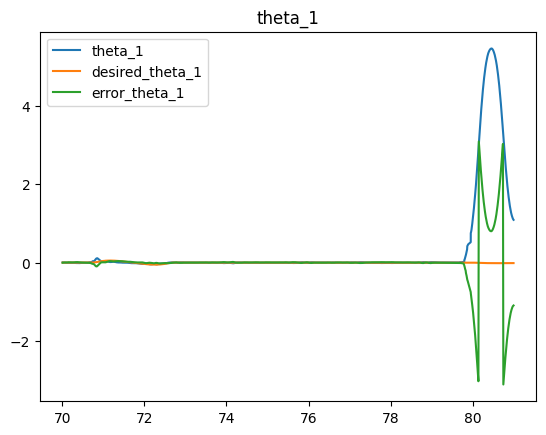

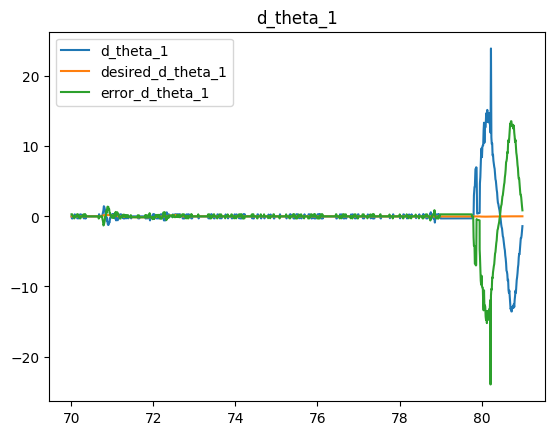

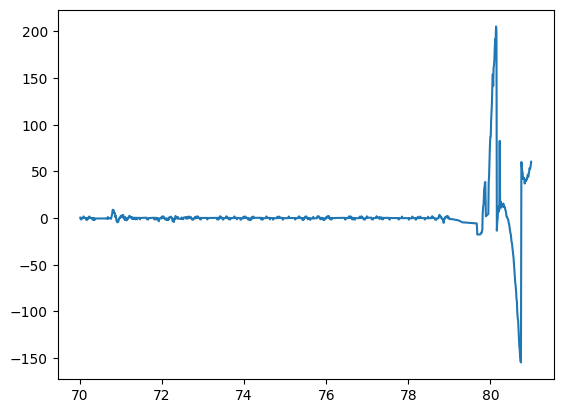

In [17]:
df = df[(df['time'] >= 70) & (df['time'] <= 81)]

time = df['time']
columns = ["s", "d_s", "theta_1", "d_theta_1"]
for column_name in columns:
    mod_pi = column_name.startswith("theta")
    desired_column_name = f"desired_{column_name}"
    error_column_name = f"error_{column_name}"
    column = df[column_name].to_numpy()
    desired_column = df[desired_column_name].to_numpy()
    error_column = df[error_column_name].to_numpy()
    if mod_pi:
        column = np.unwrap(column)
        desired_column = np.unwrap(desired_column)

    plt.plot(time, column, label=column_name)
    plt.plot(time, desired_column, label=desired_column_name)
    plt.plot(time, error_column, label=error_column_name)
    plt.legend()
    plt.title(column_name)
    plt.show()

plt.plot(time, df['u'], label='u')

In [14]:
states = np.array(df[["s", "d_s", "theta_1", "d_theta_1"]])
desired_states = np.array(df[["desired_s", "desired_d_s", "desired_theta_1", "desired_d_theta_1"]])

last_update = perf_counter()
env = CartPoleEnv(system, dt, rk4_step)
for state, desired_state in zip(states, desired_states):
    env.render(state, desired_state)
    while perf_counter() - last_update < dt:
        pass
    last_update = perf_counter()
env.close()

AttributeError: 'NoneType' object has no attribute 'fill'

In [ ]:

theta_1 = df['theta_1'].to_numpy()[1:-1]
d_theta_1 = df['d_theta_1'].to_numpy()[1:-1]
dd_theta_1 = df['d_theta_1'].diff().to_numpy()[1:-1]/dt

X = d_theta_1
dd_s = df['u'].to_numpy()[1:-1]
y = m1*l1/2*(g*np.sin(theta_1)-dd_s*np.cos(theta_1)-7*l1/2/3*dd_theta_1)

model = LinearRegression().fit(X.reshape(-1, 1), y)
print(model.coef_, model.intercept_)

[-0.01607886] 0.01803505569232426


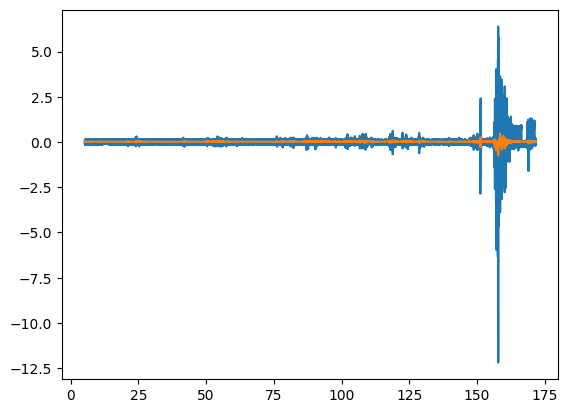

In [ ]:
y_calc = model.predict(X.reshape(-1, 1))
time = time[1:-1]
plt.plot(time, y, label='y')
plt.plot(time, y_calc, label='y_calc')